# Cross-Dispersion Width Investigation
Ricky reported a concern looking at some of the preliminary simulations that the trace produced by astrogrism's simulation module had a thicker trace than the original source. This notebook details my investigation to confirm the validity of the cross-dispersion width produced by the Astrogrism Simulation feature introduced in https://github.com/spacetelescope/astrogrism/pull/19

At the time of writing, the PR produced above does not include any subpixel dispersions; the results are "floor'ed" to the lower pixel coordinate. As a result, this notebook expects the simulation module to produce a trace that is +/- 1 pixel the size of the original source

## Simulated Sources
My first step to verify the cross-dispersion width was to begin with creating some targets of varying sizes and seeing how the trace is produced. Starting with a blank numpy array, the following cell creates five sources, each of varying widths starting from 1 pixel to 5 pixels wide. 

In [2]:
import matplotlib.pyplot as plt
from jdaviz import Imviz

In [2]:
import numpy as np
data = np.zeros((500,300))

#One pixel wide
data[480,10] = 1
#Two pixel wide
data[480,20] = 1
data[480,21] = 1
#3
data[480,30] = 1
data[480,31] = 1
data[480,32] = 1
#4
data[480,40] = 1
data[480,41] = 1
data[480,42] = 1
data[480,43] = 1
#5
data[480,50] = 1
data[480,51] = 1
data[480,52] = 1
data[480,53] = 1
data[480,54] = 1
data.shape

(500, 300)

In [3]:
from astrogrism.simulate import simulate_grism
grism_simulation = simulate_grism('G280', data, detector=1)
#plt.imshow(grism_simulation, origin = 'lower')
#plt.show()

imviz = Imviz()
imviz.load_data(grism_simulation)
imviz.app

[================================================================================================================================================] 100%


Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

If we look closely at the above traces, each trace seems to respect our expectations

In [7]:
viewer = imviz.default_viewer
viewer.center_on((200, 290))
viewer.zoom_level = 10

## Previous Simulation Analysis

The next kind of analysis that comes to mind is to look back at our old simulations and inspect the traces there, since that was where we ran into this issue originally. The following is the first simulation I ran against a TESS observation of M44 (I think?)

In [8]:
imviz_sim1 = Imviz()
# Load the direct image and astrogrism simulation
imviz_sim1.load_data('sim1_rings.v3.skycell.1709.094.stk.g.unconv.fits')
imviz_sim1.load_data('sim1_2022-03-04_GrismSimulation.fits')
simulation_image = imviz_sim1.app.get_data_from_viewer('imviz-0', 'sim1_2022-03-04_GrismSimulation[PRIMARY,1]')
# Remove the simulation from the default viewer
viewer_direct_image = imviz_sim1.app.get_viewer_by_id("imviz-0")
imviz_sim1.app.remove_data_from_viewer("imviz-0", 'sim1_2022-03-04_GrismSimulation[PRIMARY,1]')
# Create a new viewer and show the simulation on that viewer
simulation_viewer = imviz_sim1.create_image_viewer()
imviz_sim1.app.add_data_to_viewer("imviz-1", 'sim1_2022-03-04_GrismSimulation[PRIMARY,1]')
imviz_sim1.app

2022-04-28 15:31:39,269 - stpipe - WARNING - /Users/dnguyen/duydir/astrogrism/envmain/lib/python3.10/site-packages/glue/viewers/common/viewer.py:186: UserWarning: Add large data set?
  warnings.warn(message)



Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

This cell zooms the two viewers into roughly the right place; this has to be done manually because the simulation package does not write the wcs to the simulation at this time

In [11]:
viewer_direct_image.center_on((500,500))
viewer_direct_image.zoom(7)
simulation_viewer.center_on((500,500))

The best way, that I can think of, to quantitatively analyze the width of these two is to select a target, cut out the both the direct image and the dispersed trace, then do collapse to view the flux across the cross-dispersion axis. So we'll select a star that is largely isolated and cut that one out:

In [12]:
viewer_direct_image.center_on((353,271))
viewer_direct_image.zoom(5)
simulation_viewer.center_on((353,360))
simulation_viewer.zoom(5)

And now we'll cut these out and take a peak at what we'll be collapsing:

In [13]:
direct_image_cutout = imviz_sim1.app.get_data_from_viewer('imviz-0', 'sim1_rings.v3.skycell.1709.094.stk.g.unconv[COMPRESSED_IMAGE,1]')[250:300, 324:384]
simulated_trace_cutout = simulation_image[300:500, 325:385]

In [14]:
imviz_sim1_cutouts = Imviz()
# Load the direct image and astrogrism simulation
imviz_sim1_cutouts.load_data(direct_image_cutout, data_label="Direct cutout")
imviz_sim1_cutouts.load_data(simulated_trace_cutout, data_label="Simulated cutout")
# Remove the simulation from the default viewer
imviz_sim1_cutouts.app.remove_data_from_viewer("imviz-0", 'Simulated cutout[DATA]')
# Create a new viewer and show the simulation on that viewer
simulation_viewer = imviz_sim1_cutouts.create_image_viewer()
imviz_sim1_cutouts.app.add_data_to_viewer("imviz-1", 'Simulated cutout[DATA]')
imviz_sim1_cutouts.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

To compare the two collapsed flux arrays, I'll do a very rough normalization just to see them next to one another

In [15]:
direct_image_collapsed = direct_image_cutout.data.sum(axis=0)
direct_image_collapsed = direct_image_collapsed / max(direct_image_collapsed)
simulated_trace_collapsed = simulated_trace_cutout.data.sum(axis=0)
simulated_trace_collapsed = simulated_trace_collapsed / max(simulated_trace_collapsed)

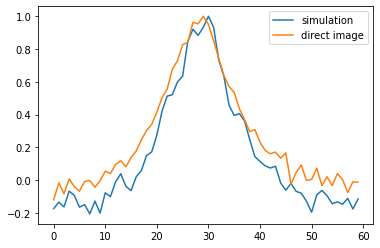

In [16]:
plt.plot(simulated_trace_collapsed, label="simulation")
plt.plot(direct_image_collapsed, label="direct image")
plt.legend()
plt.show()

Looking at these two profiles, it actually looks like the simulation's cross-dispersion profile is *narrower* than the direct image. But at that, the difference is quite small. It is very important for this analysis to note that Astrogrism's simulate feature produces a simulation that has the **same pixelscale** as the original input image, making this direct comparison possible

## Comparison with real HST grism simulation
This last comparison actualy compares the result of an astrogrism simulation against that of a real grism observation by HST. The following two observations were conducted in 2009 with the direct being observed by F098W and the dispersed by G102 on HST

In [3]:
imviz_real_obs = Imviz()
# Load real direct and dispersed data
imviz_real_obs.load_data('WFC3_G102_Direct_ib6o21qnq_flt.fits', data_label='Direct')
imviz_real_obs.load_data('WFC3_G102_Grism_ib6o21qnq_flt.fits', data_label='Grism')
# Remove Dispersed data from the first viewer (to add to the second)
imviz_real_obs.app.remove_data_from_viewer("imviz-0", 'Grism[SCI,1]')
# Create a new viewer and show the simulation on that viewer
imviz_real_obs.create_image_viewer()
imviz_real_obs.app.add_data_to_viewer("imviz-1", 'Grism[SCI,1]')
imviz_real_obs.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [4]:
from astrogrism.simulate import simulate_grism
G102_simulation = simulate_grism('G102', imviz_real_obs.app.get_data_from_viewer('imviz-0', 'Direct[SCI,1]').data)

KeyboardInterrupt: 